### __*Install packages, Imports, DataFrame*__

In [1]:

from torchmetrics import SymmetricMeanAbsolutePercentageError, MeanSquaredError, MeanAbsoluteError


import torch

from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)

from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")


%matplotlib inline

import numpy as np

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


In [2]:
# testing

import pandas as pd

import datetime as dt
import matplotlib.pyplot as plt

from darts import TimeSeries
from sklearn.preprocessing import MinMaxScaler


from darts.utils.missing_values import fill_missing_values

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler, StandardScaler
from crypto_assist.data_preprocess import preprocessor_not_scaled


            time      open      high       low     close    volume BTC  \
0     2017-08-17   4261.48   4485.39   4200.74   4285.08    795.150377   
1     2017-08-18   4285.08   4371.52   3938.77   4108.37   1199.888264   
2     2017-08-19   4108.37   4184.69   3850.00   4139.98    381.309763   
3     2017-08-20   4139.98   4211.08   4032.62   4086.29    467.083022   
4     2017-08-21   4069.13   4119.62   3911.79   4016.00    691.743060   
...          ...       ...       ...       ...       ...           ...   
2298  2023-12-02  38682.51  39717.14  38641.61  39450.35  26696.921610   
2299  2023-12-03  39450.35  40250.00  39274.86  39972.26  26710.653350   
2300  2023-12-04  39972.26  42420.00  39972.26  41991.10  79272.330590   
2301  2023-12-05  41991.10  44488.00  41414.00  44073.32  67490.746440   
2302  2023-12-06  44073.82  44297.21  43335.28  43762.69  51431.104920   

        volume USD        RSI  RSI_class        ADX  ADX_class  
0     3.454770e+06  50.000000          0   0.0

In [3]:
df = preprocessor_not_scaled('BTCUSDT_daily.csv','final_text_df.csv','social_number_data.csv','FearAndGreedIndex.csv')


            time      open      high       low     close    volume BTC  \
0     2017-08-17   4261.48   4485.39   4200.74   4285.08    795.150377   
1     2017-08-18   4285.08   4371.52   3938.77   4108.37   1199.888264   
2     2017-08-19   4108.37   4184.69   3850.00   4139.98    381.309763   
3     2017-08-20   4139.98   4211.08   4032.62   4086.29    467.083022   
4     2017-08-21   4069.13   4119.62   3911.79   4016.00    691.743060   
...          ...       ...       ...       ...       ...           ...   
2298  2023-12-02  38682.51  39717.14  38641.61  39450.35  26696.921610   
2299  2023-12-03  39450.35  40250.00  39274.86  39972.26  26710.653350   
2300  2023-12-04  39972.26  42420.00  39972.26  41991.10  79272.330590   
2301  2023-12-05  41991.10  44488.00  41414.00  44073.32  67490.746440   
2302  2023-12-06  44073.82  44297.21  43335.28  43762.69  51431.104920   

        volume USD        RSI  RSI_class        ADX  ADX_class  
0     3.454770e+06  50.000000          0   0.0

In [4]:
df.index = pd.to_datetime(df.date)


In [5]:
df.drop(columns="date",inplace=True)


In [6]:
df.tail()


,open,high,low,close,volume BTC,volume USD,RSI,RSI_class,ADX,ADX_class,FAGI_score,scored_title,scored_text,average_score,twitter_followers,twitter_favourites,reddit_subscribers,reddit_active_users,reddit_comments_per_day,FAGI_sentiment_encoded
date,,,,,,,,,,,,,,,,,,,,
2023-12-02,38682.51,39717.14,38641.61,39450.35,26696.92161,1.043422e+09,68.581366,0,43.948829,2,74.0,-0.002369,-0.004065,-0.003217,3174848.0,2163.435644,2594931.0,1747.715439,699.824346,3.0
2023-12-03,39450.35,40250.00,39274.86,39972.26,26710.65335,1.059861e+09,70.702721,1,44.436432,2,73.0,0.324950,0.944111,0.634530,3175499.0,2163.435644,2594931.0,1747.715439,699.824346,3.0
2023-12-04,39972.26,42420.00,39972.26,41991.10,79272.33059,3.285737e+09,77.134115,1,45.836661,2,74.0,0.400351,0.543259,0.471805,3177026.0,2163.435644,2594931.0,1747.715439,699.824346,3.0
2023-12-05,41991.10,44488.00,41414.00,44073.32,67490.74644,2.890205e+09,81.616552,1,47.693335,2,75.0,0.000000,0.000000,0.000000,3177793.0,2163.435644,2594931.0,1747.715439,699.824346,3.0
2023-12-06,44073.82,44297.21,43335.28,43762.69,51431.10492,2.256980e+09,79.124603,1,49.417390,2,72.0,0.000000,0.000000,0.000000,3178488.0,2163.435644,2594931.0,1747.715439,699.824346,3.0


In [7]:
df.drop(columns=["RSI"], inplace=True)


### __*Scaling and Converting the data*__

In [8]:
#freq: This parameter defines the frequency or time interval between consecutive data points in the time series.
#'D': It means that each data point in the time series corresponds to an hour

timeseries = TimeSeries.from_dataframe(df, freq='D')


In [9]:
# Here we are converting the MinMax scaler to a Time Series version of it

from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ts_scaler = Scaler(scaler)
ts_scaler_target = Scaler(scaler)


In [10]:

scaled_df = ts_scaler.fit_transform(timeseries)
ts_scaler_target = ts_scaler_target.fit(timeseries["close"])


### __*Cleaning Missing data*__

In [11]:
from darts.utils.missing_values import fill_missing_values
scaled_df = fill_missing_values(scaled_df)
scaled_df


<TimeSeries (DataArray) (date: 2303, component: 19, sample: 1)>
array([[[0.0166849 ],
        [0.01839357],
        [0.02182369],
        ...,
        [0.2445421 ],
        [0.14865773],
        [0.5       ]],

       [[0.01705172],
        [0.01666101],
        [0.01769203],
        ...,
        [0.2445421 ],
        [0.14865773],
        [0.5       ]],

       [[0.01430512],
        [0.01381835],
        [0.01629199],
        ...,
...
        ...,
        [0.2445421 ],
        [0.14865773],
        [0.75      ]],

       [[0.60311487],
        [0.6270436 ],
        [0.60873364],
        ...,
        [0.2445421 ],
        [0.14865773],
        [0.75      ]],

       [[0.6354865 ],
        [0.62414068],
        [0.63903516],
        ...,
        [0.2445421 ],
        [0.14865773],
        [0.75      ]]])
Coordinates:
  * date       (date) datetime64[ns] 2017-08-17 2017-08-18 ... 2023-12-06
  * component  (component) object 'open' 'high' ... 'FAGI_sentiment_encoded'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Train Test Split*__

<Axes: xlabel='date'>

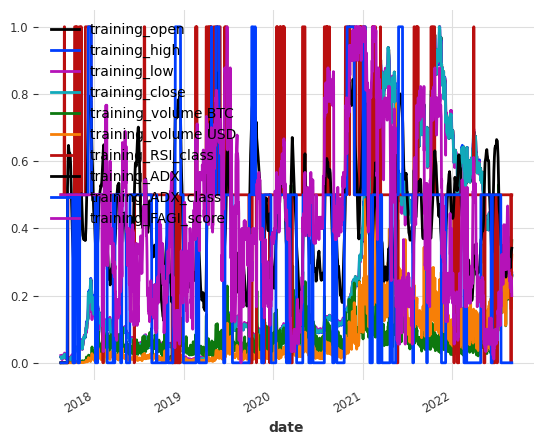

In [12]:
train, val = (scaled_df).split_before(0.8)

train.plot(label="training")


In [13]:
val,test = (val).split_before(0.5)


### __*Setup Earlystopping and the train on GPU*__

In [14]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
stopper = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0.0001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [stopper],
                   "accelerator": "cpu"
                   }


### __*Instanciate BlockRNNMODEL*__

In [15]:
# predict 7 days considering the latest 50 days


model_covariates = BlockRNNModel(
    model="LSTM",
    input_chunk_length= 45,
    output_chunk_length=7,
    torch_metrics= SymmetricMeanAbsolutePercentageError(),
    n_epochs=500,
    hidden_dim = 88,
    n_rnn_layers = 1,
    pl_trainer_kwargs = pl_trainer_kwargs,
    random_state=0,
)


### __*GridSearch*__

In [16]:
"""# predict 7 days considering the latest 50 days

model_gridSearch = BlockRNNModel(
    model="LSTM",
    input_chunk_length= 45,
    output_chunk_length=7,
    #dropout=0.1,
    #
    torch_metrics= SymmetricMeanAbsolutePercentageError(),
    n_epochs=500,
    pl_trainer_kwargs = pl_trainer_kwargs,
    random_state=0,
)
"""


'# predict 7 days considering the latest 50 days\n\nmodel_gridSearch = BlockRNNModel(\n    model="LSTM",\n    input_chunk_length= 45,\n    output_chunk_length=7,\n    #dropout=0.1,\n    #\n    torch_metrics= SymmetricMeanAbsolutePercentageError(),\n    n_epochs=500,\n    pl_trainer_kwargs = pl_trainer_kwargs,\n    random_state=0,\n)\n'

In [17]:
"""params = {
    #"model" : ["LSTM", "GRU"],
    "hidden_dim" : [10],
    "n_rnn_layers" : [5],
    #"hidden_fc_sizes" : [5],
    #"dropout" : [0.1],
    "input_chunk_length": [45],
    "output_chunk_length": [7]
}


gridresult = BlockRNNModel.gridsearch(
                        parameters=params,
                        series=[train["close"]],
                        past_covariates=train,
                        verbose=True,
                        forecast_horizon = 7
                        )"""


'params = {\n    #"model" : ["LSTM", "GRU"],\n    "hidden_dim" : [10],\n    "n_rnn_layers" : [5],\n    #"hidden_fc_sizes" : [5],\n    #"dropout" : [0.1],\n    "input_chunk_length": [45],\n    "output_chunk_length": [7]\n}\n\n\ngridresult = BlockRNNModel.gridsearch(\n                        parameters=params,\n                        series=[train["close"]],\n                        past_covariates=train,\n                        verbose=True,\n                        forecast_horizon = 7\n                        )'

In [18]:
"""best_model, dict_bestparams = gridresult
print(f"dict_bestparams: {dict_bestparams}")
"""


'best_model, dict_bestparams = gridresult\nprint(f"dict_bestparams: {dict_bestparams}")\n'

### __*Train the model*__

In [19]:
model_covariates.fit(
    series=[train["close"]],    # the target training data
    past_covariates=train,     # the multi covariate features training data
    val_series=[val["close"]],  # the target validation data
    val_past_covariates=val,   # the multi covariate features validation data
    verbose=True
)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(model=LSTM, hidden_dim=88, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=45, output_chunk_length=7, torch_metrics=SymmetricMeanAbsolutePercentageError(), n_epochs=500, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x15ee4c7f0>], 'accelerator': 'cpu'}, random_state=0)

### __*Do a prediction*__

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

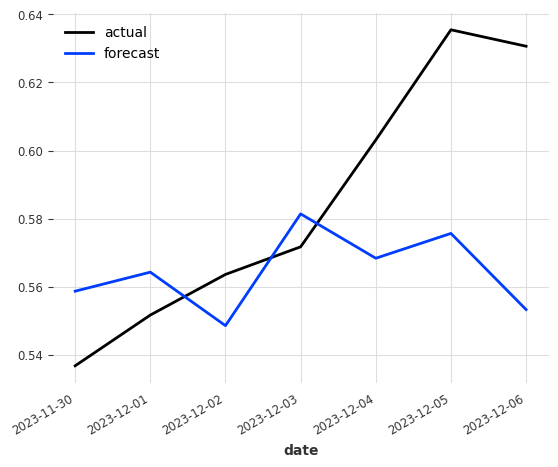

In [20]:
pred_cov = model_covariates.predict(n=7,                        # n of days to predict
                                 series=test["close"][-45-7:-7],       # target input for prediction
                                 past_covariates=test[-45-7:-7]) # past-covariates input for prediction

test[-7:]["close"].plot(label="actual")
pred_cov.plot(label="forecast")


### __*Result of the metrics*__

In [21]:
#Real Data
real_data = ts_scaler_target.inverse_transform(test['close'][-7:]).values()
real_data


array([[37723.96],
       [38682.52],
       [39450.35],
       [39972.26],
       [41991.1 ],
       [44073.32],
       [43762.69]])

### __*Turn Prediction into original scale*__

In [22]:
#Predicted Data
predicted_data = ts_scaler_target.inverse_transform(pred_cov).values()
predicted_data


array([[39133.67000955],
       [39493.37422501],
       [38482.3962803 ],
       [40594.67733251],
       [39756.22504232],
       [40225.24229899],
       [38786.05635014]])

In [23]:
# check the SMAPE error

def smape_function(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


print(smape_function(real_data, predicted_data))


5.203830836886165
